# Dataset

Sobre el Fitness Club Dataset (1501) GoalZone es una cadena de gimnasios en Canadá.

ofrece una variedad de clases de fitness en dos capacidades: 25 y 15.
Algunas clases siempre están completas.
Las clases totalmente reservadas suelen tener un bajo índice de asistencia.
Necesidad:

quiere aumentar la cantidad de espacios disponibles para clases.

Requerimiento:

Quieren hacer esto prediciendo si el miembro asistirá a la clase o no.

Resultado:

Si pueden predecir que un miembro no asistirá a la clase, pueden poner a disposición otro espacio.

## Columnas
tenemos 8 columnas:

*   `id_reserva `: (Number). El identificador único de la reserva.
*   `meses_como_miembro `: (Number).  El número de meses como miembro de este gimnasio, mínimo 1 mes.
*   `peso `: Nominal. Peso del socio en kg, redondeado a 2 decimales.
*   `días antes `: (Number). El número de días antes de la clase que el miembro se registró.
*   `día de la semana `: (String). El día de la semana de la clase.(Mon,Tue, Wed, Thu, Fri, Sat, Sun)
*   `tiempo `: (String). La hora del día de la clase. Ya sea por la mañana o por la tarde. (AM, PM)
*   `categoría `: La categoría de la clase de fitness.()
*   `asistió `: (Binario). Si el miembro asistió a la clase (1) o no (0).

# Librerías

In [211]:
# Librerías
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# For facets
from IPython.display import display, HTML
import base64
#!pip install facets-overview==1.1.1

from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance

# Cargar el Dataset

In [212]:
url_RL = "https://raw.githubusercontent.com/Darek0211/datasets/main/fitness_class_2212.csv"
datasetRL= pd.read_csv(url_RL)
datasetRL

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.5600,8,Wed,PM,Strength,0
1,2,10,79.0100,2,Mon,AM,HIIT,0
2,3,16,74.5300,14,Sun,AM,Strength,0
3,4,5,86.1200,10,Fri,AM,Cycling,0
4,5,15,69.2900,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.5100,10,Fri,AM,HIIT,0
1496,1497,29,89.5500,2,Mon,AM,Strength,0
1497,1498,9,87.3800,4,Tue,AM,HIIT,0
1498,1499,34,68.6400,14,Sun,AM,Aqua,0


Limpieza de datos

In [213]:
datasetRL=datasetRL.dropna(how="any", axis=0)
datasetRL

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.5600,8,Wed,PM,Strength,0
1,2,10,79.0100,2,Mon,AM,HIIT,0
2,3,16,74.5300,14,Sun,AM,Strength,0
3,4,5,86.1200,10,Fri,AM,Cycling,0
4,5,15,69.2900,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.5100,10,Fri,AM,HIIT,0
1496,1497,29,89.5500,2,Mon,AM,Strength,0
1497,1498,9,87.3800,4,Tue,AM,HIIT,0
1498,1499,34,68.6400,14,Sun,AM,Aqua,0


1. no tenemos datos de caracteristicas perdidas.
2. hay un tendencia mayor a la mitad de las reseves de las clases donde las personas no aisisten.
3. dentro de las categorias existen sesgo como:
* Aqua:
Sesgo de género: Los estereotipos de género pueden influir en las expectativas sobre quién debería participar en clases de entrenamiento acuático puesto que se puede asumir que esta cartegiria es para las mujeres por eso vemos poca participacion de las personas.
* Strength (Fuerza): Puede haber un sesgo que sugiera que el entrenamiento de fuerza es solo para personas jóvenes, lo que podría disuadir a personas mayores de participar,.
4. peso puede el modelo tener un sesgo ya que Si estos rangos de peso se utilizan para tomar decisiones importantes, como la admisión a clases de fitness, la asignación de entrenadores personales o la evaluación del progreso de un cliente, podría haber un sesgo de discriminación si no se trata a todas las personas de manera justa y equitativa, Dependiendo de cómo se utilicen estos rangos de peso, podría haber un sesgo de estigmatización hacia las personas que se encuentran en ciertas categorías. Por ejemplo,si se asignan valores más bajos a los rangos de peso más altos, esto podría llevar a la estigmatización de las personas con sobrepeso u obesidad.

Procesamiento de datos

In [214]:
# Salida esperada del modelo
y_Data_RL = datasetRL['attended']

# conjunto de entrada
x_Data_RL = np.column_stack((datasetRL["months_as_member"],
                          datasetRL["weight"],
                          datasetRL["days_before"],
                          datasetRL["day_of_week"],
                          datasetRL["time"],
                          datasetRL["category"],))
x_Data_RL, y_Data_RL

(array([[17, 79.56, 8, 'Wed', 'PM', 'Strength'],
        [10, 79.01, 2, 'Mon', 'AM', 'HIIT'],
        [16, 74.53, 14, 'Sun', 'AM', 'Strength'],
        ...,
        [9, 87.38, 4, 'Tue', 'AM', 'HIIT'],
        [34, 68.64, 14, 'Sun', 'AM', 'Aqua'],
        [20, 94.39, 8, 'Thu', 'AM', 'Cycling']], dtype=object),
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1495    0
 1496    0
 1497    0
 1498    0
 1499    1
 Name: attended, Length: 1467, dtype: int64)

Transformar datos tipo string a int

In [215]:
# Metodo de transformada de entrada x
# Le entra la data y el número de columna donde esta la categoría
# es decir contandop de 1 a n
# donde n es la columna donde esta la categoría
# n-1 posición de categoría
# n-2 posición de timepo
# n-3 posición día de la semana
def funTranforInfo (inuData, space):
    # Definir el diccionario de mapeo para reeemplazar los objetos por su equivalencia en número
    # day_of_week
    mapeo_day_of_week = {"Mon": 0,"Tue": 1,"Wed": 2,"Thu": 3,"Fri": 4,"Sat": 5,"Sun": 6}
    # Time
    mapeo_Time = {"AM": 0,"PM": 1}
    # category
    mapeo_category  = {"Aqua": 0, "Yoga":1, "Strength":2, "Cycling":3, "HIIT":4}

    # day_of_week
    columna_a_transformar_1 = inuData[:, space-3]

    columna_transformada_1 = np.vectorize(lambda x: mapeo_day_of_week.get(x, x))(columna_a_transformar_1)

    inuData[:, space-3] = columna_transformada_1

    # time
    columna_a_transformar_2 = inuData[:, space-2]

    columna_transformada_2 = np.vectorize(lambda x: mapeo_Time.get(x, x))(columna_a_transformar_2)

    inuData[:, space-2] = columna_transformada_2

    # Category
    columna_a_transformar_3 = inuData[:, space-1]

    columna_transformada_3 = np.vectorize(lambda x: mapeo_category.get(x, x))(columna_a_transformar_3)

    inuData[:, space-1] = columna_transformada_1

    return inuData

In [216]:
# se ejecuta el método de adaptación del cambio
x_Data_RL = funTranforInfo(x_Data_RL,6)

x_Data_RL, y_Data_RL

(array([[17, 79.56, 8, 2, 1, 2],
        [10, 79.01, 2, 0, 0, 0],
        [16, 74.53, 14, 6, 0, 6],
        ...,
        [9, 87.38, 4, 1, 0, 1],
        [34, 68.64, 14, 6, 0, 6],
        [20, 94.39, 8, 3, 0, 3]], dtype=object),
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1495    0
 1496    0
 1497    0
 1498    0
 1499    1
 Name: attended, Length: 1467, dtype: int64)

Normalización

In [217]:
scaler=MinMaxScaler()
x_scaledRL=scaler.fit_transform(x_Data_RL)
x_Data_RL

array([[17, 79.56, 8, 2, 1, 2],
       [10, 79.01, 2, 0, 0, 0],
       [16, 74.53, 14, 6, 0, 6],
       ...,
       [9, 87.38, 4, 1, 0, 1],
       [34, 68.64, 14, 6, 0, 6],
       [20, 94.39, 8, 3, 0, 3]], dtype=object)

División del dataset

In [218]:
x_trainRL, x_testRL, y_trainRL, y_testRL = train_test_split(x_Data_RL, y_Data_RL, test_size=0.3, random_state=42)

Entrenamiento del modelo de Regresión Logística

In [219]:
modeloRL = LogisticRegression()
modeloRL.fit(x_trainRL, y_trainRL)

LogisticRegression()

Predicción del modelo

In [220]:
y_predRL=modeloRL.predict(x_testRL)

Evaluación del modelo de prueba

In [221]:
accuracy = accuracy_score(y_testRL, y_predRL)
confusion = confusion_matrix(y_testRL, y_predRL)
print("accuracy: ", accuracy)
print("confusion: ", confusion)

accuracy:  0.7755102040816326
confusion:  [[291  22]
 [ 77  51]]


Matriz de confusión


Métricas de Rendimiento:
      ACCURACY  PRECISION  RECALL    AUC
Test    0.7755     0.6986  0.3984 0.6641


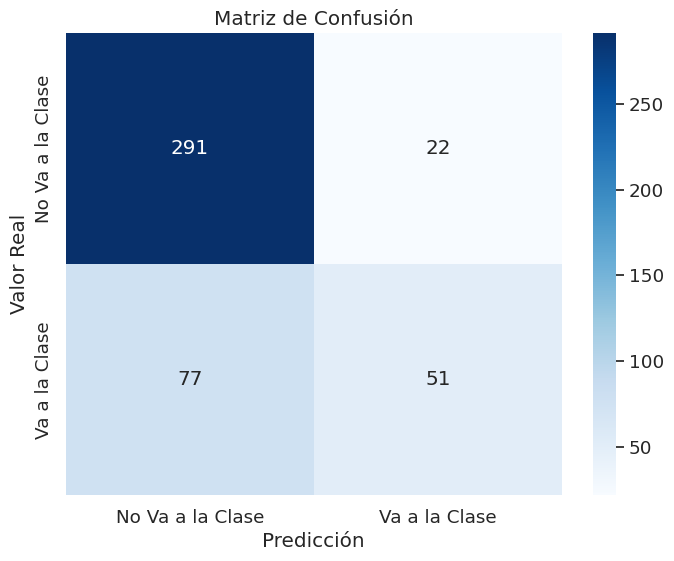

In [222]:
# Crea un DataFrame para mostrar las métricas de rendimiento
accuracy = accuracy_score(y_testRL, y_predRL)
precision = precision_score(y_testRL, y_predRL)
recall = recall_score(y_testRL, y_predRL)
auc = roc_auc_score(y_testRL, y_predRL)
#confusion = confusion_matrix(y_testRL, y_predRL)

# Crea un DataFrame para mostrar las métricas de rendimiento
performance_df = pd.DataFrame({
    'ACCURACY': [accuracy],
    'PRECISION': [precision],
    'RECALL': [recall],
    'AUC': [auc]
}, index=["Test"])
pd.options.display.float_format = '{:,.4f}'.format

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Va a la Clase', 'Va a la Clase'], yticklabels=['No Va a la Clase', 'Va a la Clase'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Muestra la matriz de confusión y las métricas de rendimiento
#print("Matriz de Confusión:")
#print(confusion)
print("\nMétricas de Rendimiento:")
print(performance_df)

performance_df
plt.show()

# Interpretabilidad con ELI5

Modelo con ELI5 para la regresión logistica.

In [223]:
model = RandomForestClassifier(random_state=42)
model.fit(x_trainRL, y_trainRL)
datasetRL

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.5600,8,Wed,PM,Strength,0
1,2,10,79.0100,2,Mon,AM,HIIT,0
2,3,16,74.5300,14,Sun,AM,Strength,0
3,4,5,86.1200,10,Fri,AM,Cycling,0
4,5,15,69.2900,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.5100,10,Fri,AM,HIIT,0
1496,1497,29,89.5500,2,Mon,AM,Strength,0
1497,1498,9,87.3800,4,Tue,AM,HIIT,0
1498,1499,34,68.6400,14,Sun,AM,Aqua,0


Entrenamiento del modelo

In [224]:
# Crear una instancia de PermutationImportance
perm = PermutationImportance(model, random_state=42)

# Ajustar la instancia a los datos de prueba
perm.fit(x_testRL, y_testRL)


PermutationImportance(estimator=RandomForestClassifier(random_state=42),
                      random_state=42)

Interpretabilidad

In [225]:
all_columns = datasetRL.columns.tolist()
feature_names = [col for col in all_columns if col not in ["booking_id", "attended"]]
eli5.show_weights(perm, feature_names=feature_names)


Weight,Feature
0.1283 ± 0.0530,months_as_member
0.0249 ± 0.0261,weight
0.0050 ± 0.0078,category
0.0009 ± 0.0110,time
-0.0027 ± 0.0133,days_before
-0.0027 ± 0.0145,day_of_week
